In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# Домашняя работа 5

Поработаем с датасетом о [пользователях кредитных карт](https://www.kaggle.com/arjunbhasin2013/ccdata). 

Мы хотим кластеризовать пользователей на категории для того, чтобы по-разному настраивать рекламу на них.

In [95]:
df = pd.read_csv('../data/CC GENERAL.csv')
df = df.drop('CUST_ID', axis=1)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [96]:
print(df.isnull().sum(), '\n\n Num of lines', df.shape[0])

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64 

 Num of lines 8950


In [97]:
df = df.dropna() # количество нулевых строк незначительно, поэтому просто удалим их

In [98]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003978,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080892,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012263,0.008210,0.000000,1.0
3,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013373,0.003204,0.000000,1.0
4,0.095038,1.000000,0.027188,0.000000,0.059257,0.000000,0.666667,0.000000,0.583333,0.000000,0.00000,0.022346,0.058431,0.027602,0.031506,0.000000,1.0


## Easy

Выдвинуть гипотезу по каким признакам нужно кластеризовать пользователей. Провести кластеризацию одним любым методом, проанализировать "на глаз" насколько хорошо получилось, можно ли как-то проинтерпретировать кластеры?

Будем производить кластеризацию по всем признакам, которые более-менее не дискретны (иначе результат кластеризации очень предсказуем и выполнить данное деление можно алгоритмически; более того, очевидно, что такое деление не будет полезным, ибо ни один из параметров не является определяющим для того или иного предложения).

In [99]:
# начнем без нормализации
df_clast = df[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']]

In [100]:
model = KMeans(n_clusters=3)
model_labels = model.fit_predict(df_clast)

In [101]:
embedding = TSNE()
embedding_data = embedding.fit_transform(df_clast)

<Axes: >

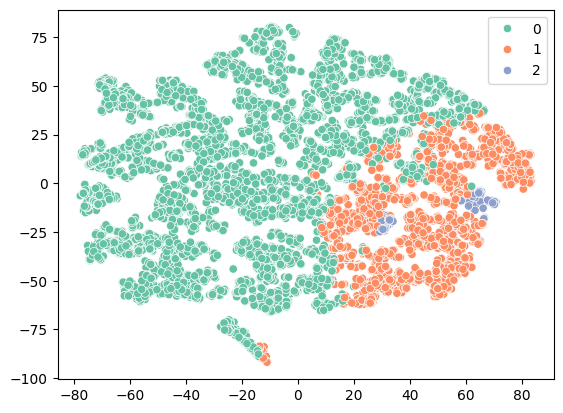

In [102]:
sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))

На самом деле результат очень предсказуем, ибо либо данные сильно связаны, либо практически независимы. Из-за этого ккластеров как таковых не существует, поэтому модель (и последующие модели) работает хреново.

## Normal

Провести кластеризацию несколькими методами. Объяснить какой результат лучше и почему. Проинтерпретировать кластеры в лучшем разбиении.

In [119]:
def claster_info(clear_model):
    model_labels = clear_model.fit_predict(df_clast)

    sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2260188105.py:4: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))


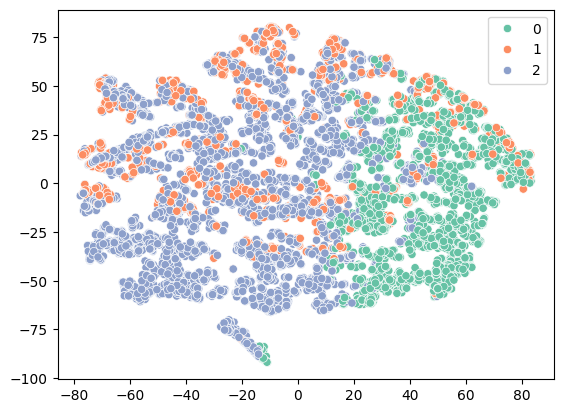

In [120]:
claster_info(AgglomerativeClustering(n_clusters=3)) # при n больших 3 кластеры получаются слишком маленькими

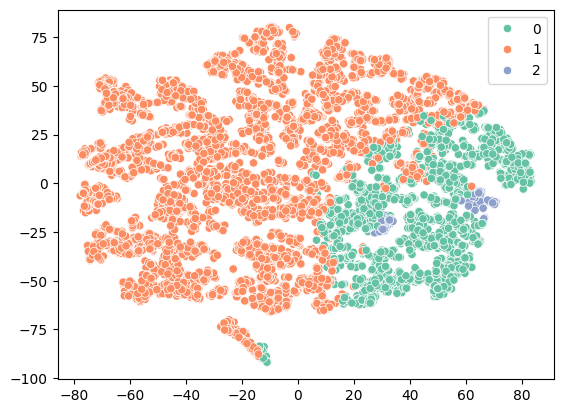

In [105]:
claster_info(KMeans(n_clusters=3))

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\661420219.py:4: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))


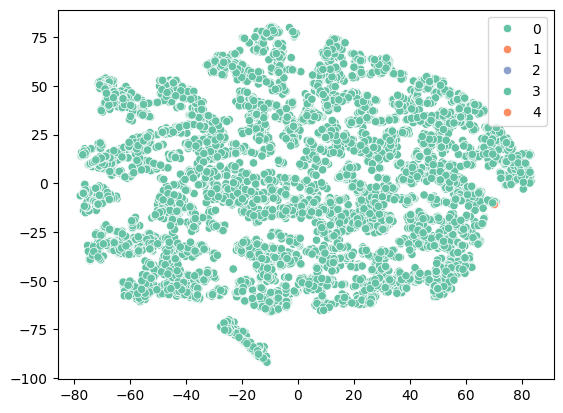

In [106]:
claster_info(DBSCAN(eps=20000, min_samples=1)) # работает очень плохо, при малых eps и при больших: кластеры всегда слишком мелкие

На самом деле, при делении на 2 кластера, `KMeans` и `AgglomerativeClustering` дадут два более-менее адекватных кластера.

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\661420219.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))


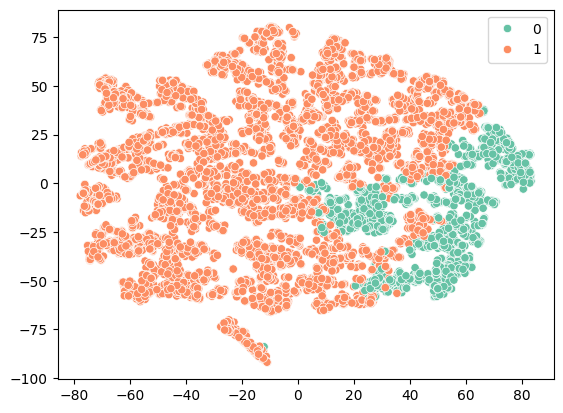

In [107]:
model = AgglomerativeClustering(n_clusters=2)
claster_info(model)
model_labels = model.fit_predict(df_clast)

In [108]:
df_clast['LABELS'] = model_labels
model_labels

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2954543583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clast['LABELS'] = model_labels


array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

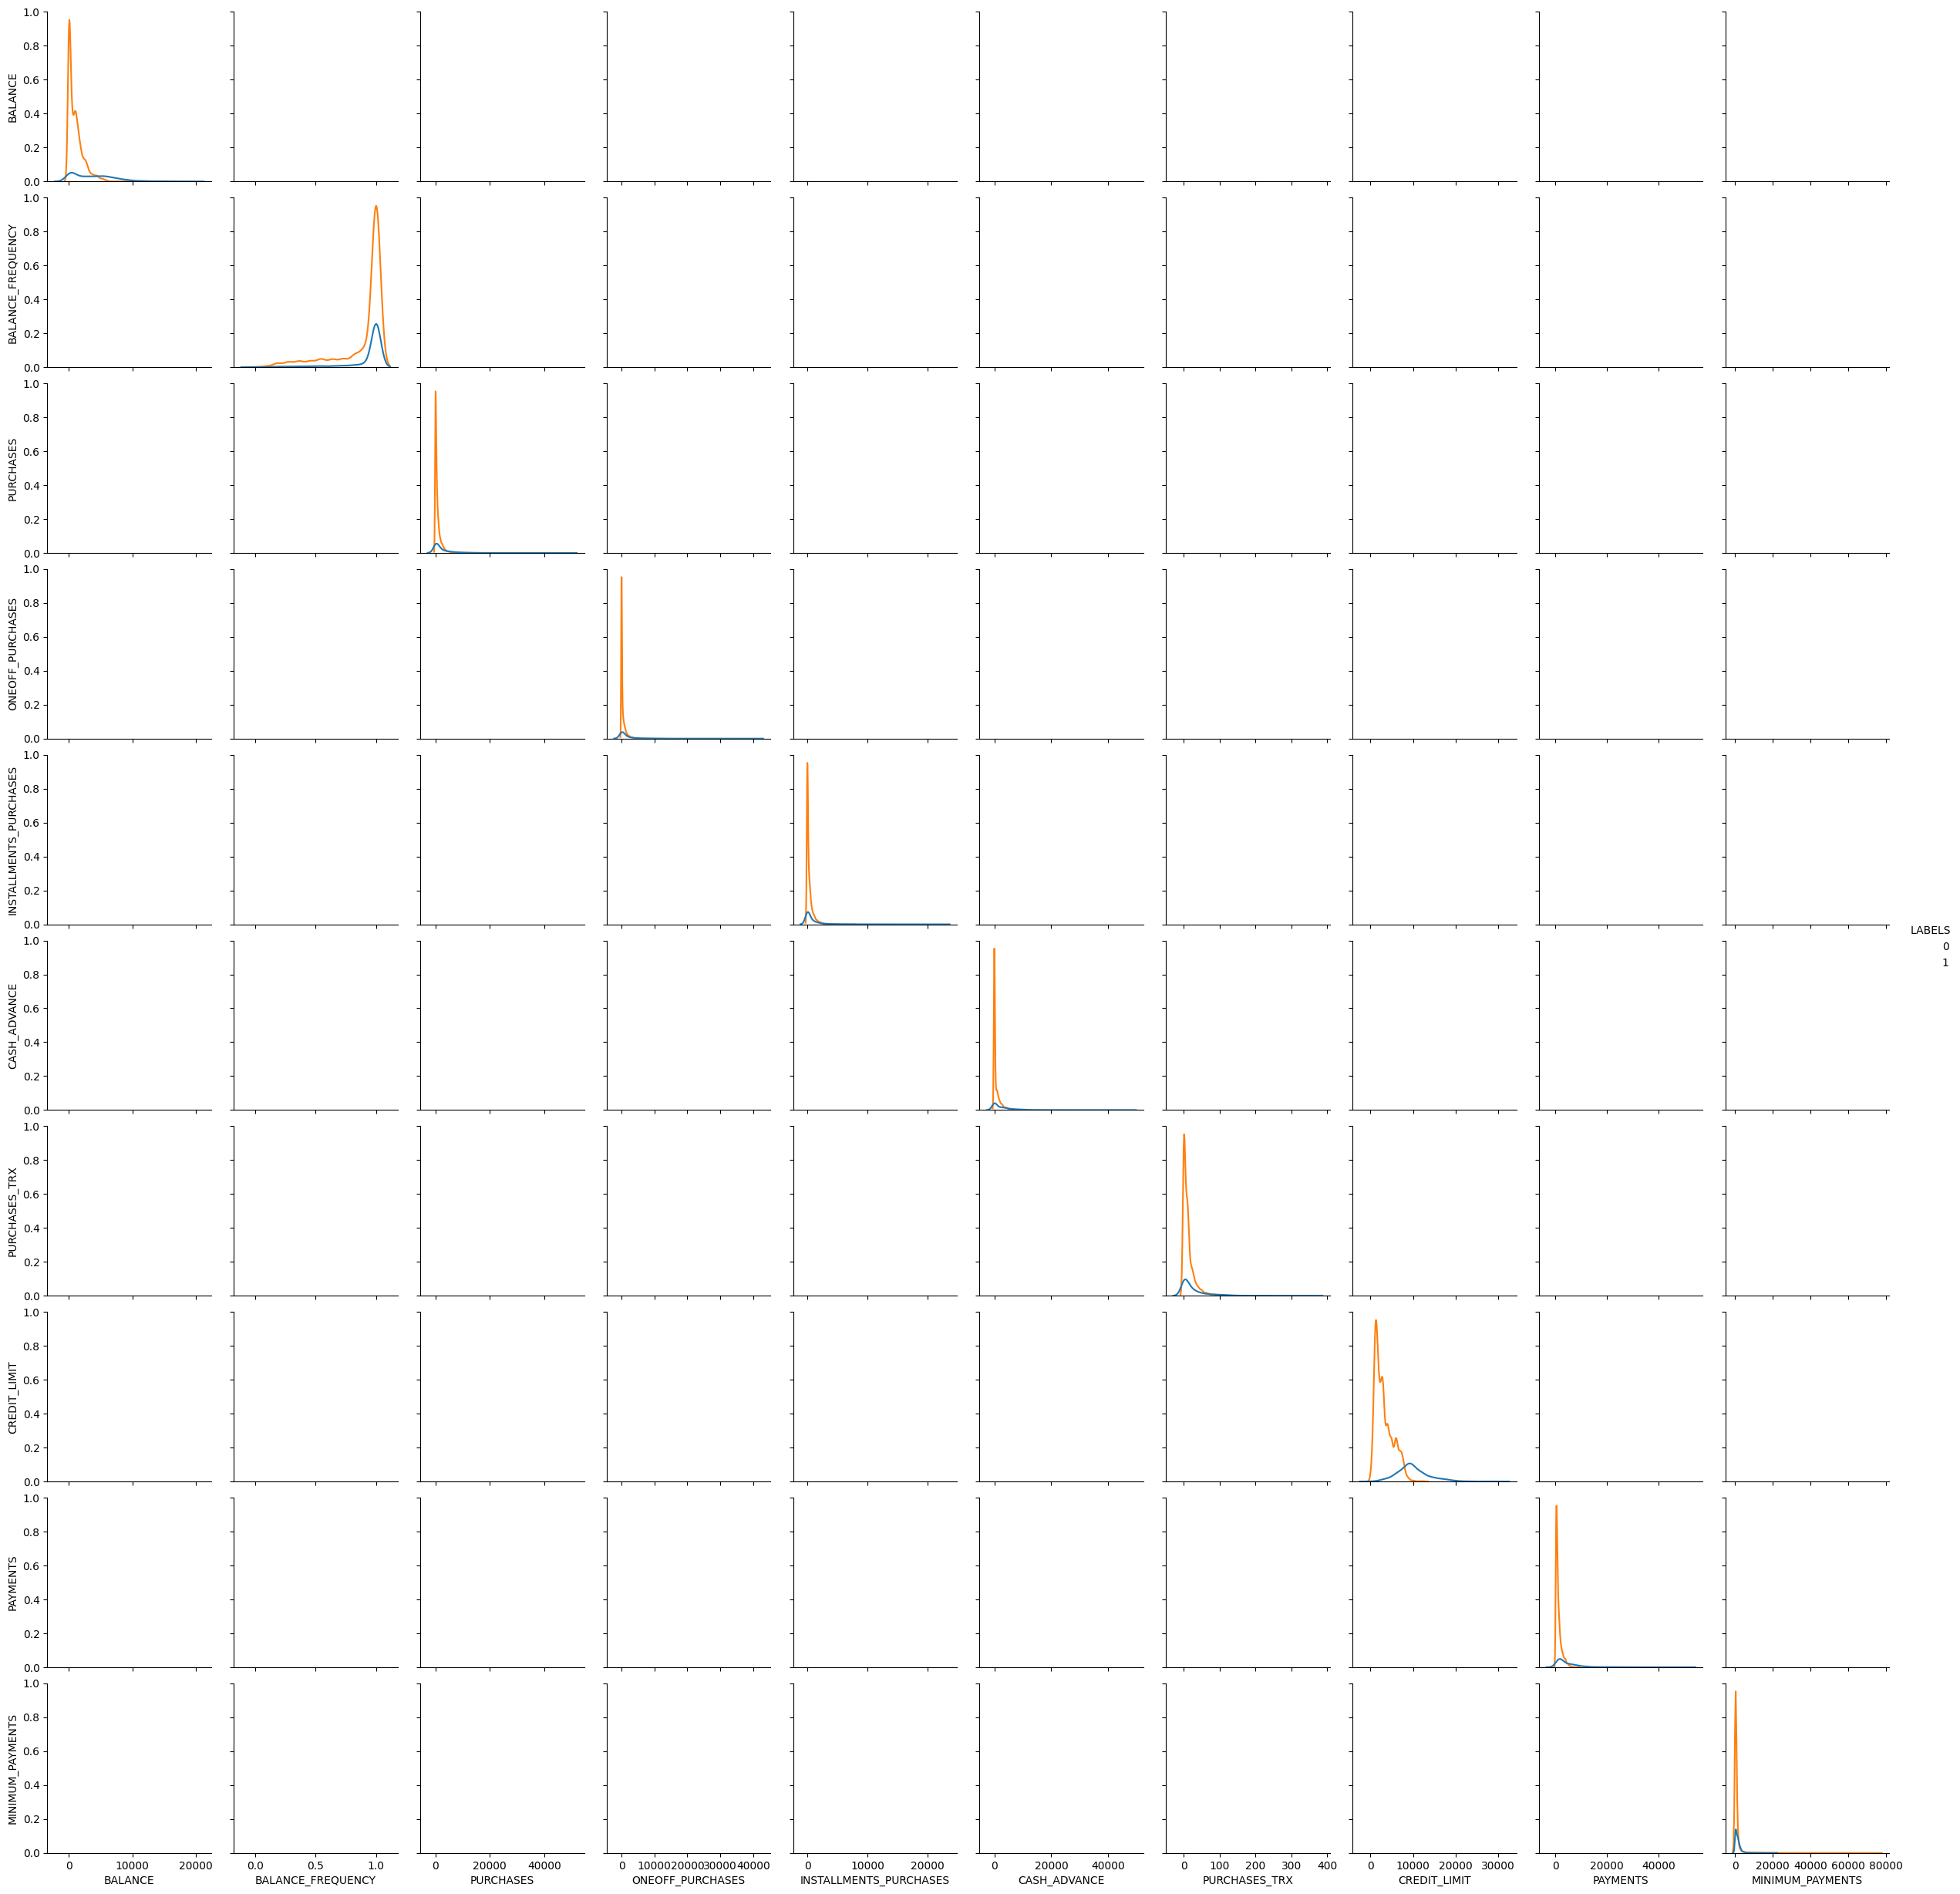

In [109]:
pg = sns.PairGrid(df_clast, hue='LABELS').map_diag(sns.kdeplot).add_legend()

for i in range(len(pg.diag_axes)):
    ax = pg.diag_axes[i]

    mi_arr = 100000000
    ma_arr = 0
    for j in range(len(ax.lines)):
        line = ax.lines[j]
        mi_arr = min(mi_arr, min(line.get_ydata()))
        ma_arr = max(ma_arr, max(line.get_ydata()))

    for j in range(len(ax.lines)):
        line = ax.lines[j]
        arr = line.get_ydata()
        norm_arr = [(i - mi_arr) / (ma_arr - mi_arr) for i in arr]
        line.set_ydata(norm_arr)
        ax.set_ylim(0,1.05)
        ax.autoscale_view()

In [110]:
# Теперь с нормализацией (работать станет сильно лучше)
df_clast = df_scaled[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']]

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2260188105.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))


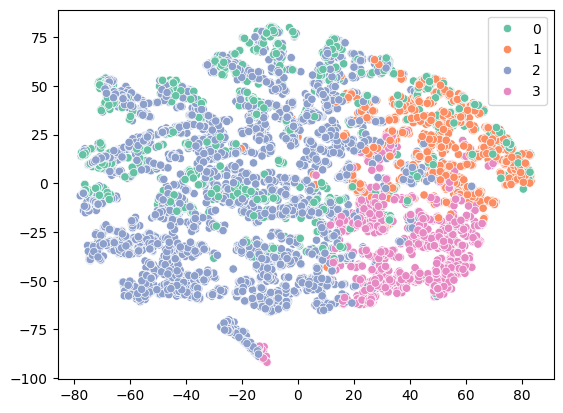

In [124]:
claster_info(AgglomerativeClustering(n_clusters=4))

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2260188105.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))


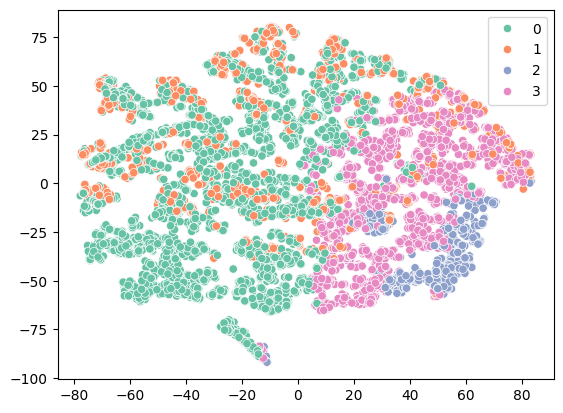

In [125]:
claster_info(KMeans(n_clusters=4))

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2260188105.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))


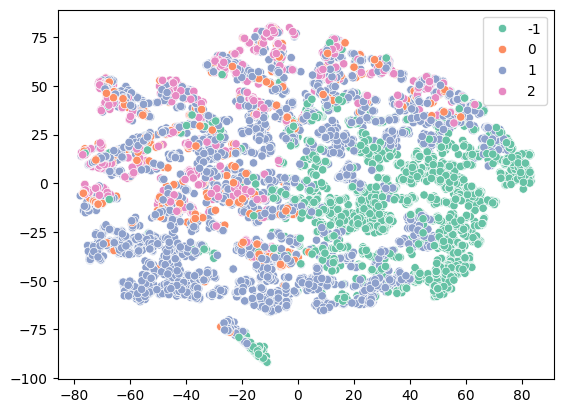

In [132]:
claster_info(DBSCAN(eps=0.05, min_samples=20))

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2260188105.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 5))


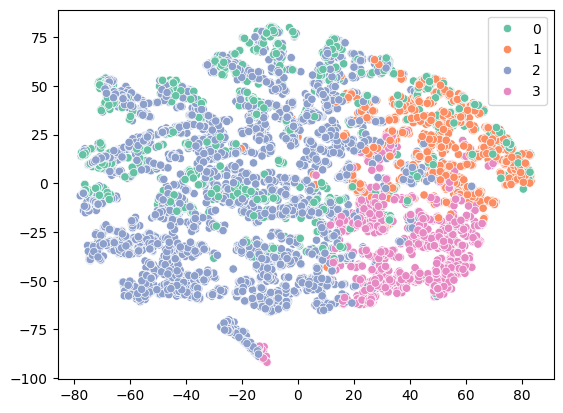

In [139]:
model = AgglomerativeClustering(n_clusters=4)
claster_info(model)
model_labels = model.fit_predict(df_clast)

Кажется, теперь рабивается нормально. Однако возникает какой-то странный разряженный класс `0`, который также возникает в `2` и `3` кластерах.

In [134]:
df_clast['LABELS'] = model_labels
model_labels

C:\Users\setday\AppData\Local\Temp\ipykernel_25844\2954543583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clast['LABELS'] = model_labels


array([2, 3, 2, ..., 2, 2, 0], dtype=int64)

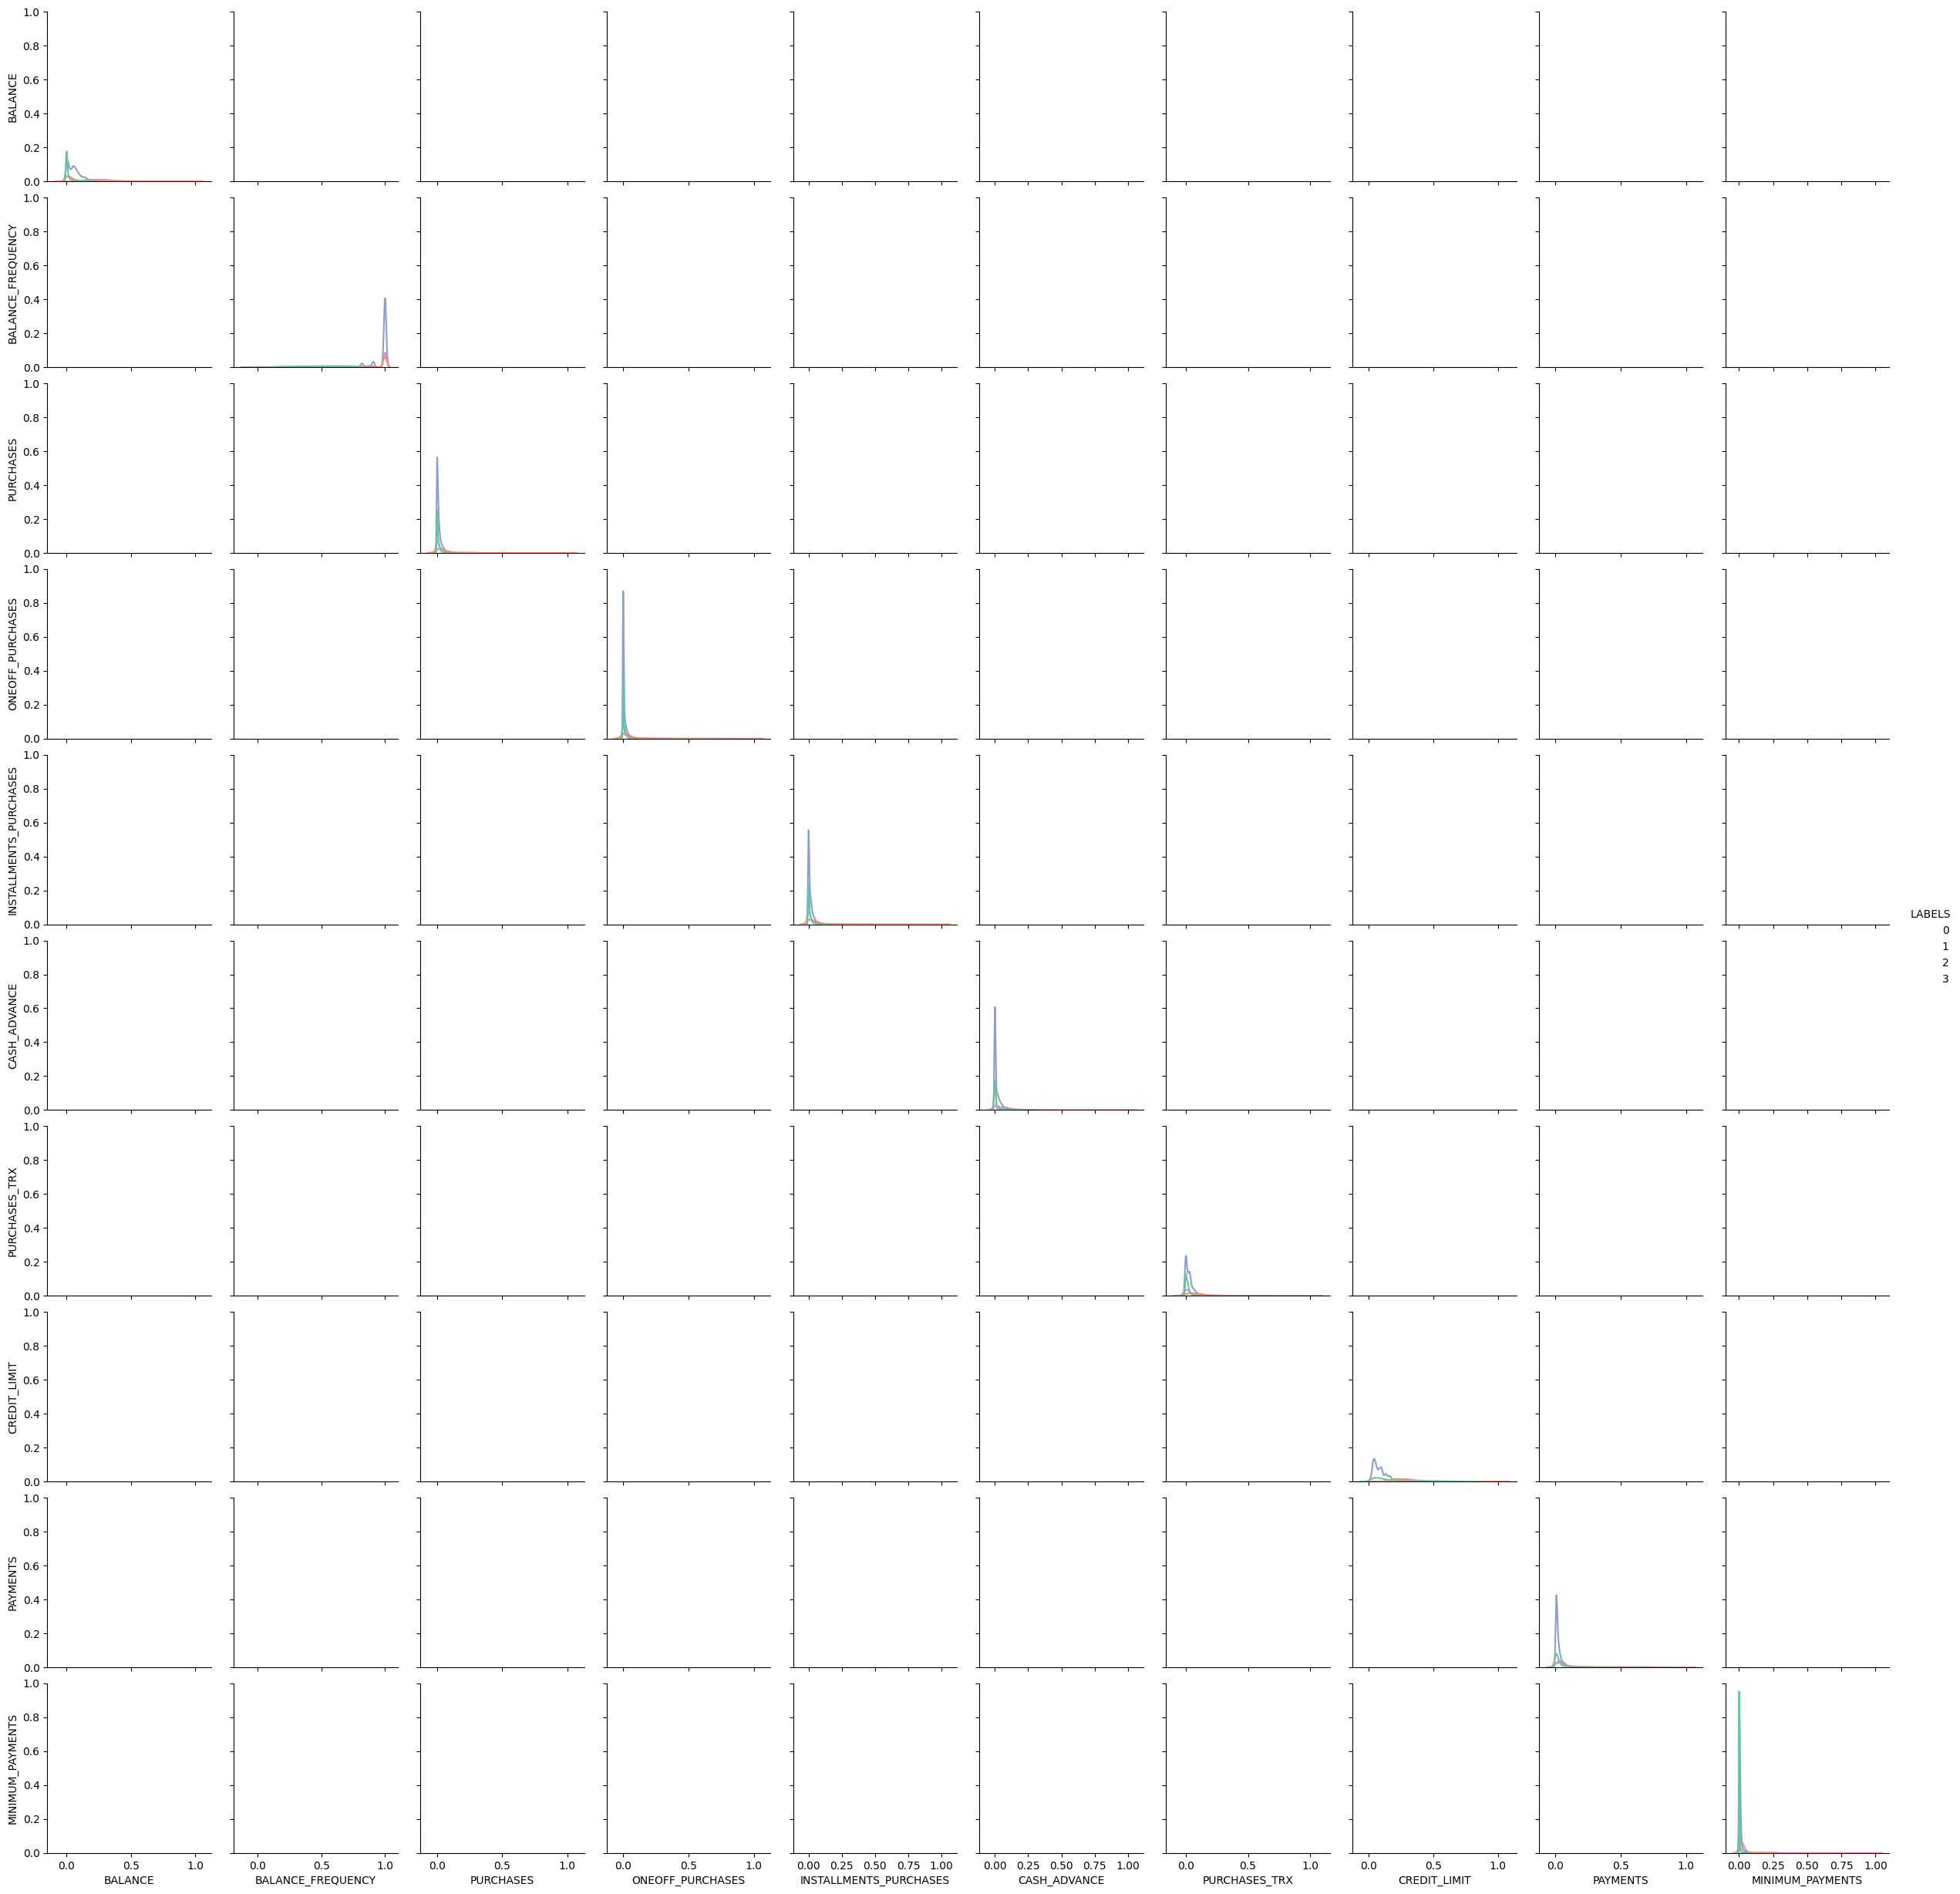

In [137]:
pg = sns.PairGrid(df_clast, hue='LABELS', palette=sns.color_palette('Set2', 4)).map_diag(sns.kdeplot).add_legend()

В целом, можно назвать раюиение удачным для наших данных. Однако из-за структуры самих данных, а именно отсутствия самих кластеров (данные сильно связаны), разбиение могло быть удачным только с дискретными величинами.

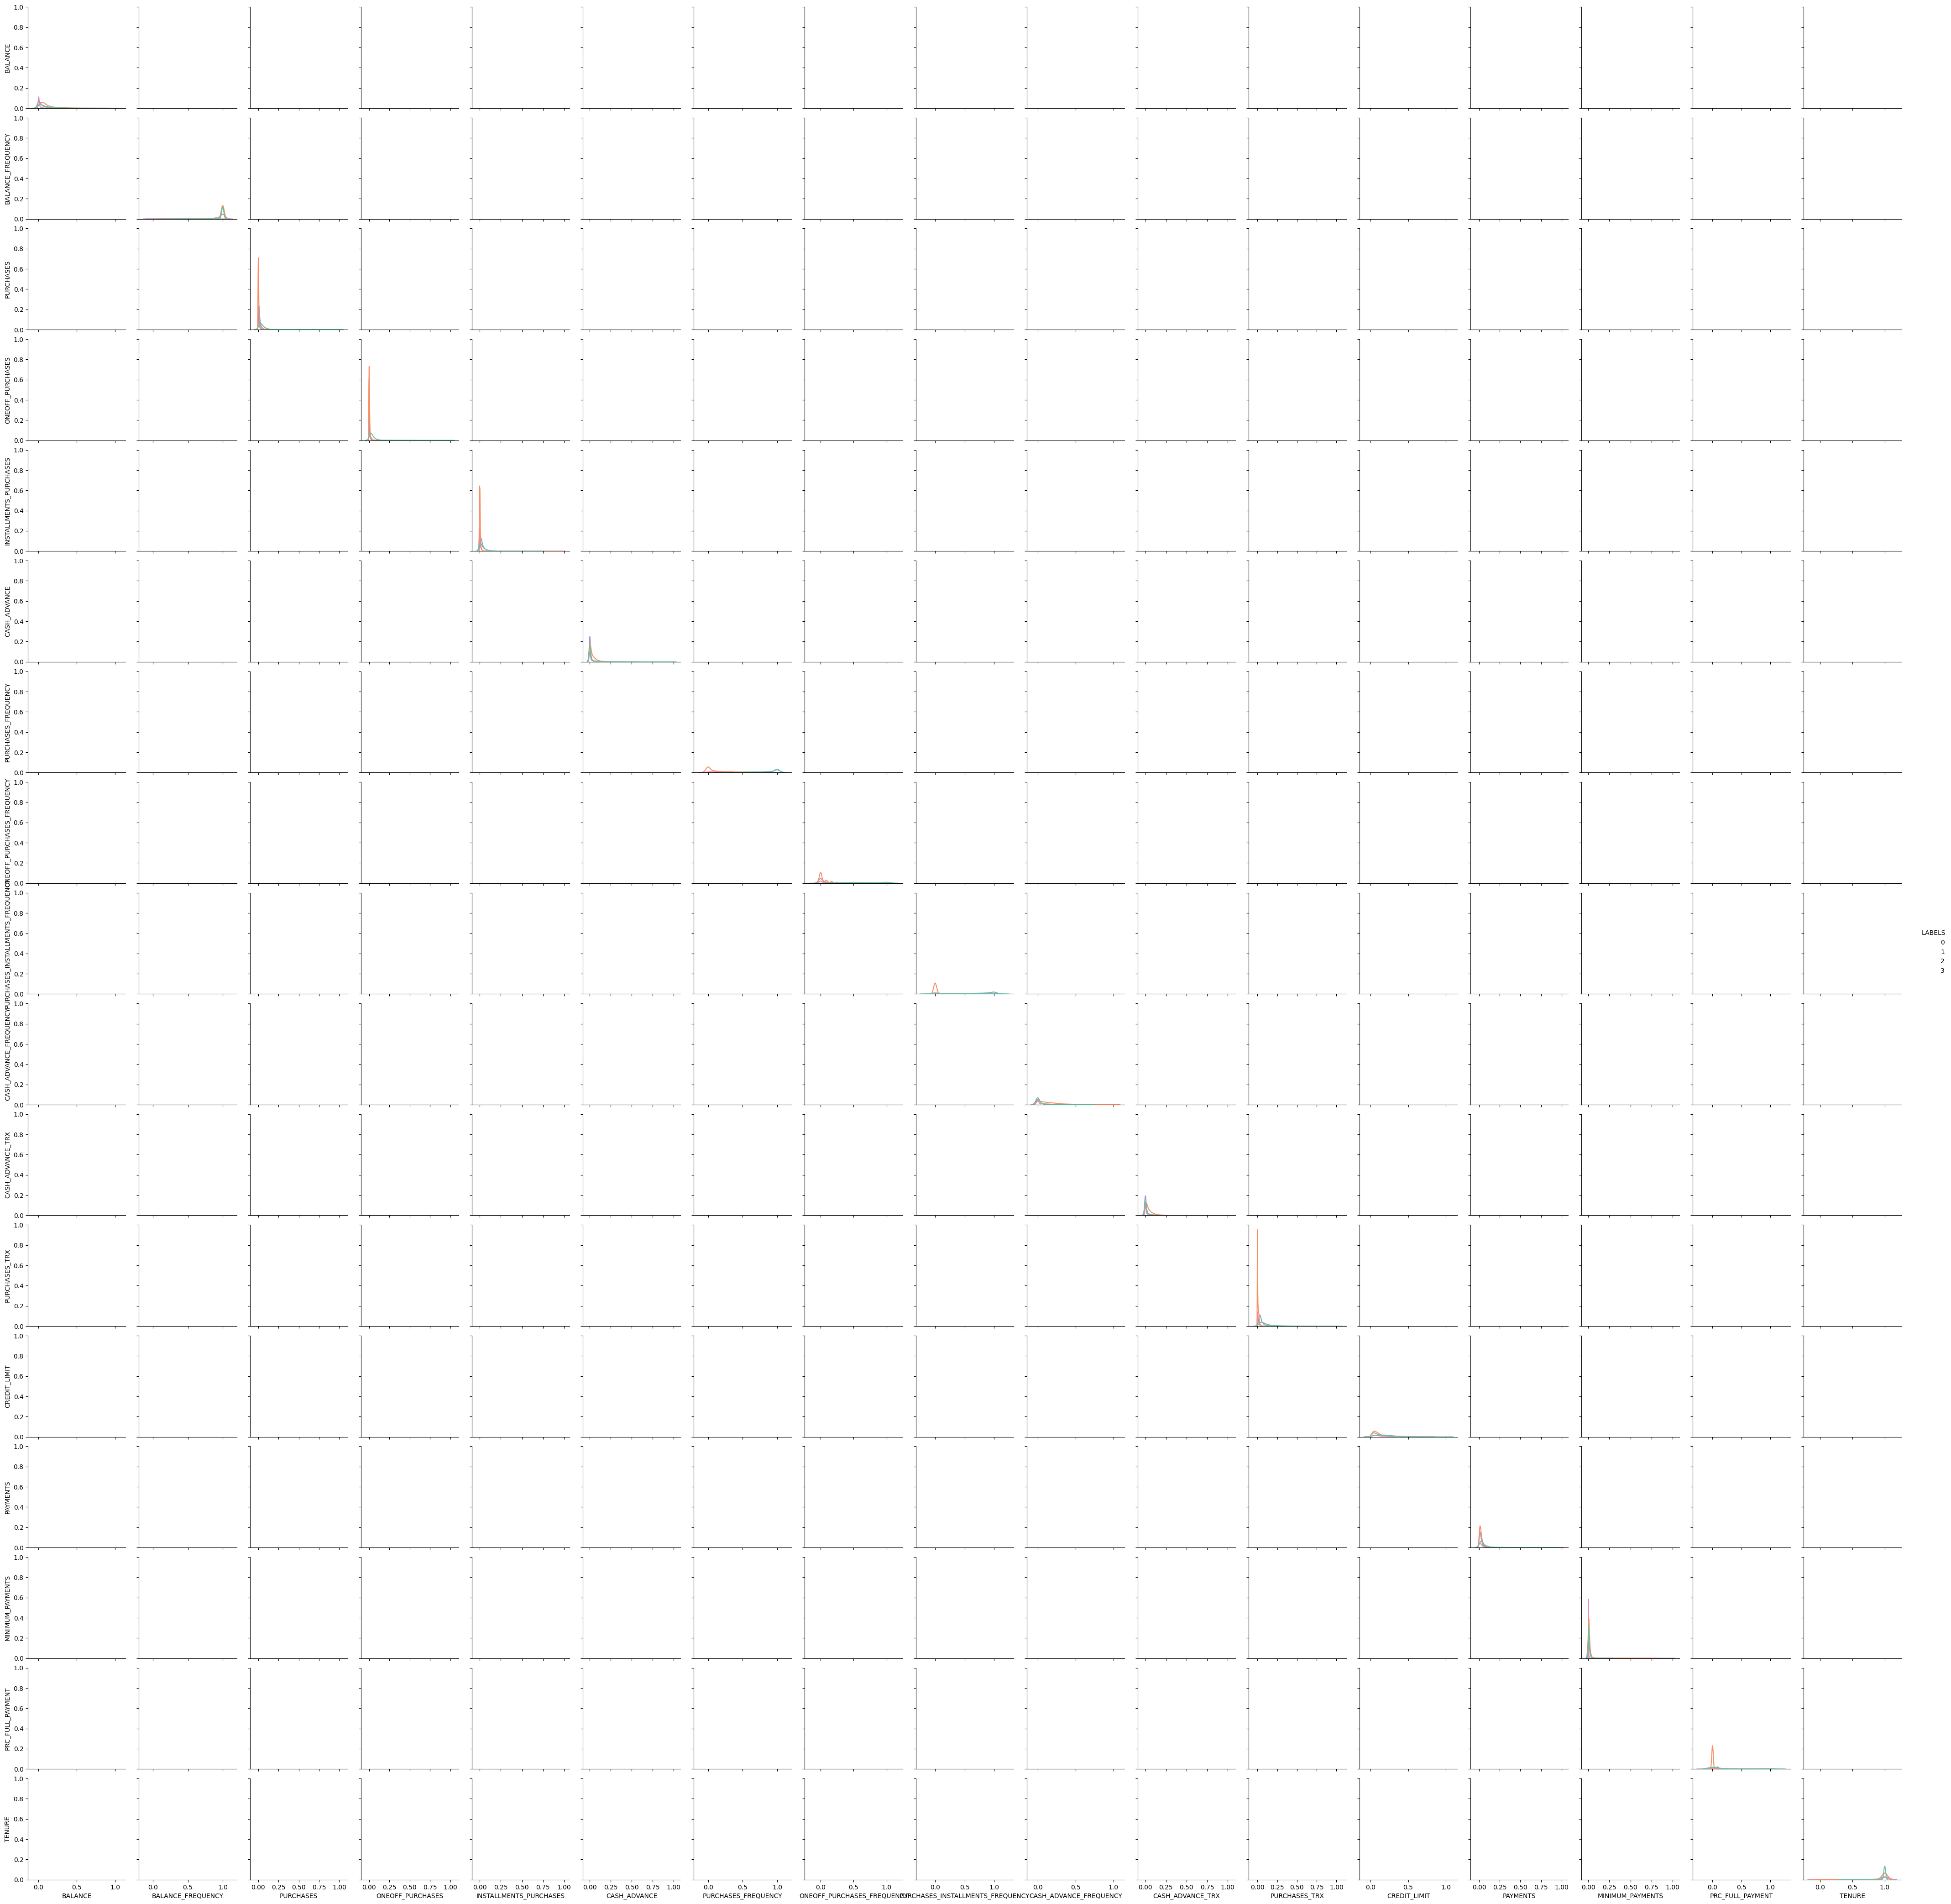

In [141]:
model = AgglomerativeClustering(n_clusters=4)
model_labels = model.fit_predict(df_scaled)

df_scaled['LABELS'] = model_labels
model_labels

pg = sns.PairGrid(df_scaled, hue='LABELS', palette=sns.color_palette('Set2', 4)).map_diag(sns.kdeplot).add_legend()

Разбиение получилось тоже хорошим. Но проинтерпретировать получается лишь два класса - зелёный и оранжевый - те, кто часто что-то покупает и те, кто покупает менее часто (забавно, что при этом не больше). Есть ещё слабо интерпретируемый класс - розовый - те, кто имеют малый достаток.

## Hard

Построить модель, которая будет предсказывать, насколько обеспеченный пользователь. Добавить в такую модель кластеризацию/метод понижения размерности и проверить, можно ли улучшить качество (или хотя бы не потерять), уменьшив при этом размер датасета?

Важно: в этой задаче нужно определить, что такое "обеспеченный пользователь" и не переобучиться (сделать так, чтобы в train и test были действительно разные данные, которые никак друг с другом не связаны)

## Полезные ссылки

- [Цикл статей о алгоритмах кластеризации](https://habr.com/ru/post/321216/)
- [Про нечеткую кластеризацию](https://en.wikipedia.org/wiki/Fuzzy_clustering)
- [Подробнее про метод главных компонент](https://habr.com/ru/post/304214/)
- [Как подобрать платье с помощью метода главных компонент](https://habr.com/ru/company/io/blog/265089/)